In [1]:
import tqdm as notebook_tqdm
from tqdm import tqdm

# for data
import json
import pandas as pd
import numpy as np
import csv

# for processing
import re
import numpy as np
from sklearn.model_selection import train_test_split
import math

pd.options.mode.chained_assignment = None  # default='warn'

# Reading Dataset

In [2]:
def reading_data(data_file):
    # Dari Json file untuk training data
    data_file = pd.read_json(data_file)
    data_file = data_file.sort_values(by=['haditsId'])
    data_file = data_file.reset_index()
    data_file = data_file[["kitabId","indo"]]
    return data_file

In [3]:
bukhari = reading_data('Dataset/RawData/bukhari.json')
bukhari.head()

,kitabId,indo
0,1,Telah menceritakan kepada kami [Al Humaidi Abd...
1,1,Telah menceritakan kepada kami [Abdullah bin Y...
2,1,Telah menceritakan kepada kami [Yahya bin Buka...
3,1,Telah menceritakan kepada kami [Musa bin Isma'...
4,1,Telah menceritakan kepada kami [Abdan] dia ber...


In [5]:
def reading_data_result(data_file):
    # Membaca data untuk data hasil
    data_file = pd.read_json(data_file)
    data_file = data_file.sort_values(by=['haditsId'])
    data_file = data_file.reset_index()
    data_file = data_file[["haditsId" , "kitabId","indo", "arab" ]]
    return data_file

In [7]:
bukhari = reading_data_result('Dataset/RawData/bukhari.json')
bukhari.head()

,haditsId,kitabId,indo,arab
0,1,1,Telah menceritakan kepada kami [Al Humaidi Abd...,حَدَّثَنَا الْحُمَيْدِيُّ عَبْدُ اللَّهِ بْنُ ...
1,2,1,Telah menceritakan kepada kami [Abdullah bin Y...,حَدَّثَنَا عَبْدُ اللَّهِ بْنُ يُوسُفَ قَالَ أ...
2,3,1,Telah menceritakan kepada kami [Yahya bin Buka...,حَدَّثَنَا يَحْيَى بْنُ بُكَيْرٍ قَالَ حَدَّثَ...
3,4,1,Telah menceritakan kepada kami [Musa bin Isma'...,حَدَّثَنَا مُوسَى بْنُ إِسْمَاعِيلَ قَالَ حَدّ...
4,5,1,Telah menceritakan kepada kami [Abdan] dia ber...,حَدَّثَنَا عَبْدَانُ قَالَ أَخْبَرَنَا عَبْدُ ...


In [8]:
bukhari.to_csv('bukhari.csv', index= False)

# Preprocessing

## Remove Sanad

In [5]:
def string_sanad(hadits):
    # menghapus kalimat yang memiliki sanad
    # Array to String
    result = ""
    for kata in hadits:
        if kata.find("[")==-1:
            result += kata
    return result

def only_sanad(hadits):
    # hanya Menghapus nama Sanad
    # Array to String
    result = ""
    for kata in hadits:        
        temp = re.sub(r"(?<=\[)(.*?)(?=\])","",kata)
        result += temp
    return result

def only_sanad2(hadits):
    # hanya Menghapus nama Sanad
    # string to String
    result = re.sub(r"(?<=\[)(.*?)(?=\])","",hadits)
    return result

def removing_sanad(hadits_book):
    result = hadits_book.copy()
    for i in tqdm(range(0, len(hadits_book))):
        hadits_temp1 = []
        hadits_temp2 = ""
        
        if hadits_book['indo'][i].find('""') != -1:
            # ada beberapa hadits dengan tanda petik ada 2 kali
            hadits_temp1 = re.findall(r'(?<=\")"(.*?)"(?=\")',hadits_book['indo'][i])
            for hadits in hadits_temp1:
                hadits_temp2 += hadits
            # jika hadits tidak ada dalam tanda petik, pembagian dengan bantuan tanda '.'
            if hadits_temp2 == "" or hadits_temp2 == " ":
                hadits_temp1 = re.split('""|\.|,',hadits_book['indo'][i])
                # Menemukan bagian hadits yang tidak tercantum nama sanad pada "[]"
                hadits_temp2 = string_sanad(hadits_temp1)   
                if hadits_temp2 == "" or hadits_temp2 == " ":
                    hadits_temp2 = only_sanad2(hadits_book['indo'][i])
                                
        elif hadits_book['indo'][i].find('"') != -1:
            # Mengambil hadits yang memiliki tanda petik
            hadits_temp1 = re.findall(r"(?<=\")(.*?)(?=\")",hadits_book['indo'][i])
            for hadits in hadits_temp1:
                hadits_temp2 += hadits
            # jika hadits tidak ada dalam tanda petik, pembagian dengan bantuan tanda '.' dan ','
            if hadits_temp2 == "" or hadits_temp2 == " ":
                hadits_temp1 = re.split('"|\.|,',hadits_book['indo'][i])
                # Menemukan bagian hadits yang tidak tercantum nama sanad pada "[]"
                hadits_temp2 = string_sanad(hadits_temp1)   
                if hadits_temp2 == "" or hadits_temp2 == " ":
                    hadits_temp2 = only_sanad2(hadits_book['indo'][i])
                
        elif hadits_book['indo'][i].find(',') != -1:
            # Membagi hadits dengan tanda ','
            hadits_temp1 = hadits_book['indo'][i].split(',')
            # Menemukan bagian hadits yang tidak tercantum nama sanad pada "[]"
            hadits_temp2 = string_sanad(hadits_temp1)
            # Jika setiap bagian hadis memiliki nama sanad
            if hadits_temp2 == "" or hadits_temp2 == " ":
                hadits_temp2 = only_sanad(hadits_temp1)
                    
        else: # tidak ada tanda ',' dan '"'
             # hanya hilangkan nama sanad
            hadits2 = only_sanad(hadits_book['indo'][i])
            hadits_temp2 += hadits2       
            
        # Hilangkan Tanda baca
        hadits_temp2 = re.sub(r"[^\w\s]","",hadits_temp2)
        result['indo'][i] = hadits_temp2
    return result

In [8]:
# bukhari = reading_data('hadits/data/bukhari.json')
remove_sanad = removing_sanad(bukhari)
remove_sanad2 = removing_sanad2(bukhari)
# remove_sanad.to_csv(r'NoSanad/bukhari.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 7008/7008 [00:02<00:00, 3229.58it/s]


In [9]:
bukhari['indo'][55]

'Telah menceritakan kepada kami [Abu An Nu\'man] berkata, telah menceritakan kepada kami [Abu \'Awanah] dari [Ziyad bin \'Alaqah] berkata; saya mendengar [Jarir bin Abdullah] berkata ketika Al Mughirah bin Syu\'bah meninggal, sambil berdiri dia memuji Allah dan mensucikan-Nya, berkata: "Wajib atas kalian bertakwa kepada Allah satu-satunya dan tidak menyekutukannya, dan dengan penuh ketundukan dan ketenangan sampai datang pemimpin pengganti, dan sekarang datang penggantinya, " kemudian dia berkata: "Mintakanlah maaf kepada Allah Subhanahu wa Ta\'ala buat pemimpin kalian ini (Al Mughirah), karena dia suka memberi maaf." Lalu berkata: "Amma ba\'du, sesungguhnya aku mendatangi Nabi shallallahu \'alaihi wasallam kemudian aku berkata: "Aku membai\'at engkau untuk Islam". Lalu Nabi shallallahu \'alaihi wasallam memberi syarat dan menasehati kepada setiap muslim, maka aku membai\'at Beliau untuk perkara itu, dan demi Pemilik Masjid ini, sungguh aku akan selalu memberi nasihat kepada kalian" Ke

In [11]:
remove_sanad['indo'][55]

'Wajib atas kalian bertakwa kepada Allah satusatunya dan tidak menyekutukannya dan dengan penuh ketundukan dan ketenangan sampai datang pemimpin pengganti dan sekarang datang penggantinya  kemudian dia berkata Mintakanlah maaf kepada Allah Subhanahu wa Taala buat pemimpin kalian ini Al Mughirah karena dia suka memberi maaf Lalu berkata Amma badu sesungguhnya aku mendatangi Nabi shallallahu alaihi wasallam kemudian aku berkata Aku membaiat engkau untuk Islam Lalu Nabi shallallahu alaihi wasallam memberi syarat dan menasehati kepada setiap muslim maka aku membaiat Beliau untuk perkara itu dan demi Pemilik Masjid ini sungguh aku akan selalu memberi nasihat kepada kalian'

In [492]:
remove_sanad.head()

,kitabId,indo
0,1,Semua perbuatan tergantung niatnya dan balasan...
1,1,Wahai Rasulullah bagaimana caranya wahyu turun...
2,1,Permulaaan wahyu yang datang kepada Rasulullah...
3,1,Berkata Ibnu Abbas Rasulullah shallallahu ala...
4,1,bahwa Rasulullah shallallahu alaihi wasallam ...


In [7]:
def removing_sanad2(hadits_book):
    # Hanya Menghapus nama Perawi
    result = hadits_book.copy()
    for i in tqdm(range(0, len(hadits_book))):
        hadits_temp1 = ""
        hadits_temp1 = only_sanad2(hadits_book['indo'][i])
        hadits_temp1 = re.sub(r"[^\w\s]","",hadits_temp1)
        result['indo'][i] = hadits_temp1
    return result

In [496]:
bukhari = reading_data('hadits/data/bukhari.json')
remove_sanad2 = removing_sanad2(bukhari)
remove_sanad2.to_csv(r'NoSanad_name/bukhari.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 7008/7008 [00:01<00:00, 3747.06it/s]


In [497]:
remove_sanad2.head()

,kitabId,indo
0,1,Telah menceritakan kepada kami dia berkata Te...
1,1,Telah menceritakan kepada kami berkata telah ...
2,1,Telah menceritakan kepada kami berkata Telah ...
3,1,Telah menceritakan kepada kami dia berkata Te...
4,1,Telah menceritakan kepada kami dia berkata te...


In [21]:
# Melakukan random under sampling dan duplicate oversampling
def undersampling_oversampling(hadits):
    # Mencari rata2 jml hadits/ kelas
    counter = len(hadits) / hadits['kitabId'][len(hadits)-1]
    counter = round(counter)
    
    # Deskripsi dataset
    desc = hadits.groupby('kitabId').describe()
    
    # Under_Sampling
    hadits_under = pd.DataFrame()
    for i in tqdm(range(1, len(desc)+1),  desc="Processing Undersampling"):
        class_temp = hadits[hadits['kitabId']== i]
        if desc['indo']['count'][i] > counter:        
            class_temp = class_temp.sample(counter)
            hadits_under = pd.concat([hadits_under, class_temp], axis=0)
        else:
            hadits_under = pd.concat([hadits_under, class_temp], axis=0)
        
    # Over_Sampling
    hadits_over = pd.DataFrame()
    for i in tqdm(range(1, len(desc)+1),  desc="Processing Oversampling"):
        class_temp = hadits_under[hadits_under['kitabId']== i]
        if desc['indo']['count'][i] < counter:
            hitung = math.ceil(counter/len(class_temp))
            class_temp = pd.concat([class_temp]*hitung, ignore_index=True)
            class_temp = class_temp.truncate(after=(counter-1))
            hadits_over= pd.concat([hadits_over, class_temp], axis=0)
        else:
            hadits_over = pd.concat([hadits_over, class_temp], axis=0)
    hadits_over = hadits_over.reset_index(drop=True)
    return hadits_over

In [22]:
# Melakukan structured under sampling dan duplicate oversampling
def undersampling_oversampling_sort(hadits):
    # Mencari rata2 jml hadits/ kelas
    counter = len(hadits) / hadits['kitabId'][len(hadits)-1]
    counter = round(counter)
    
    # Deskripsi dataset
    desc = hadits.groupby('kitabId').describe()
    
    # Under_Sampling
    hadits_under = pd.DataFrame()
    for i in tqdm(range(1, len(desc)+1),  desc="Processing Undersampling"):
        class_temp = hadits[hadits['kitabId']== i]
        if desc['indo']['count'][i] > counter:        
            s = class_temp.indo.str.len().sort_values(ascending = False).index
            class_temp = class_temp.reindex(s)
            class_temp = class_temp.reset_index(drop=True)
            class_temp = class_temp.truncate(after=(counter-1))
            hadits_under = pd.concat([hadits_under, class_temp], axis=0)
        else:
            hadits_under = pd.concat([hadits_under, class_temp], axis=0)
        
    # Over_Sampling
    hadits_over = pd.DataFrame()
    for i in tqdm(range(1, len(desc)+1),  desc="Processing Oversampling"):
        class_temp = hadits_under[hadits_under['kitabId']== i]
        if desc['indo']['count'][i] < counter:
            hitung = math.ceil(counter/len(class_temp))
            class_temp = pd.concat([class_temp]*hitung, ignore_index=True)
            class_temp = class_temp.truncate(after=(counter-1))
            hadits_over= pd.concat([hadits_over, class_temp], axis=0)
        else:
            hadits_over = pd.concat([hadits_over, class_temp], axis=0)
    hadits_over = hadits_over.reset_index(drop=True)
    return hadits_over

In [499]:
# Untuk split data, dan save data
def trainTestSplit_Bert(data, file_output_train, file_output_test, file_output_valid):
    data.rename(columns = {'kitabId':'label', 'indo': 'hadits'}, inplace = True)
    train, rem = train_test_split(data, test_size=0.2, shuffle=True, stratify= data.label.values)
    valid, test = train_test_split(rem, test_size=0.5, shuffle=True)
    train.to_csv(file_output_train, index=False)
    test.to_csv(file_output_test, index=False)
    valid.to_csv(file_output_valid, index=False)

In [28]:
bukhari2 = undersampling_oversampling_sort(remove_sanad)

Processing Oversampling: 100%|████████████████████████████████████████████████████████| 77/77 [00:00<00:00, 695.85it/s]


In [24]:
bukhari2.to_csv(r'svm_data/bukhari_ns.csv', index=False)

In [476]:
trainTestSplit_Bert(bukhari2, 'Bert_data/ns/bukhari_train.csv', 'Bert_data/ns/bukhari_test.csv', 'Bert_data/ns/bukhari_valid.csv' )

In [473]:
len(bukhari2)

7007

In [27]:
a = remove_sanad.groupby('kitabId').describe()
a

indo                                                               
        count unique                                                top freq
kitabId                                                                     
1           6      6  Semua perbuatan tergantung niatnya dan balasan...    1
2          50     50  Islam dibangun diatas lima landasan persaksian...    1
3          75     73  celakalah bagi tumittumit yang tidak basah aka...    2
4         108    108  Rasulullah shallallahu alaihi wasallam bersabd...    1
5          45     45   bahwa jika Nabi shallallahu alaihi wasallam m...    1
...       ...    ...                                                ...  ...
73         81     81  Siapa yang mentaatiku berarti ia mentaati Alla...    1
74         20     20  Demi Dzat yang jiwaku berada di tanganNYA kala...    1
75         21     21  Kami mendatangi Nabi shallallahu alaihi wasall...    1
76         97     97  Seorang lakilaki Yahudi berkata kepada Umar Wa...    1
77        186    185   Rasulullah shallallahu alaihi wasallam bersabda     2

[77 rows x 4 columns]

In [29]:
a = bukhari2.groupby('kitabId').describe()
a

indo                                                               
        count unique                                                top freq
kitabId                                                                     
1          91      6  Semua perbuatan tergantung niatnya dan balasan...   16
2          91     50  Islam dibangun diatas lima landasan persaksian...    2
3          91     73  celakalah bagi tumittumit yang tidak basah aka...    3
4          91     91  Ketika Rasulullah shallallahu alaihi wasallam ...    1
5          91     45   bahwa jika Nabi shallallahu alaihi wasallam m...    3
...       ...    ...                                                ...  ...
73         91     81  Siapa yang mentaatiku berarti ia mentaati Alla...    2
74         91     20  Demi Dzat yang jiwaku berada di tanganNYA kala...    5
75         91     21  Kami mendatangi Nabi shallallahu alaihi wasall...    5
76         91     91   Ia meneruskan Aku terus bertolak hingga kutem...    1
77         91     91  Kami bertanya Ya Rasulullah apakah kita akan m...    1

[77 rows x 4 columns]

In [31]:
max(a['indo']['count'])

482

In [32]:
min(a['indo']['count'])

3

In [ ]:
#------------------

In [507]:
bukhari.head()

,kitabId,indo
0,1,Telah menceritakan kepada kami [Al Humaidi Abd...
1,1,Telah menceritakan kepada kami [Abdullah bin Y...
2,1,Telah menceritakan kepada kami [Yahya bin Buka...
3,1,Telah menceritakan kepada kami [Musa bin Isma'...
4,1,Telah menceritakan kepada kami [Abdan] dia ber...


In [504]:
save = bukhari.groupby('kitabId').describe()

In [505]:
save.to_csv(r'bukhari_desc.csv', index=False)

In [257]:
data = reading_data('hadits/data/muslim.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/muslim.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 5362/5362 [00:01<00:00, 3710.27it/s]


In [124]:
muslim = pd.read_csv('NoSanad/muslim.csv')
muslim.head()

,kitabId,indo
0,1,Barangsiapa menceritakan hadits dariku yang ma...
1,1,Rasulullah shallallahu alaihi wasallam bersabd...
2,1,Barangsiapa yang sengaja melakukan kedustaan a...
3,1,Rasulullah shallallahu alaihi wasallam bersabd...
4,1,Aku mendatangi masjid sedangkan alMughirah gub...


In [258]:
data = reading_data('hadits/data/abudaud.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/abudaud.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 4590/4590 [00:01<00:00, 3890.28it/s]


In [125]:
abudaud = pd.read_csv('NoSanad/abudaud.csv')
abudaud.head()

,kitabId,indo
0,1,maka beliau menjauh
1,1,maka beliau pergi hingga tidak ada seorang pu...
2,1,Apabila salah seorang dari kalian hendak buang...
3,1,Ya Allah sesungguhnya aku berlindung kepadamu ...
4,1,Sesungguhnya tempat buang hajat itu dihadiri o...


In [259]:
data = reading_data('hadits/data/darimi.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/darimi.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 3367/3367 [00:00<00:00, 3939.91it/s]


In [126]:
darimi = pd.read_csv('NoSanad/darimi.csv')
darimi.head()

,kitabId,indo
0,1,ia berkata Datang kepada Rasulullah shallalla...
1,1,kami dahulu adalah orangorang jahiliyah penye...
2,1,ia berkata keluargaku melarangku makan keju k...
3,1,ia berkata kami dulu pada masa jahiliyah apab...
4,1,beliau tidak kasar tutur katanya tidak keras ...


In [260]:
data = reading_data('hadits/data/ibnumajah.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/ibnumajah.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 4332/4332 [00:01<00:00, 4116.57it/s]


In [127]:
ibnumajah = pd.read_csv('NoSanad/ibnumajah.csv')
ibnumajah.head()

,kitabId,indo
0,1,Apa yang aku perintahkan maka ambillah dan apa...
1,1,Biarkanlah apa yang telah aku tinggalkan untuk...
2,1,Barangsiapa mentaatiku maka ia telah taat kep...
3,1,Ibnu Umar Jika mendengar sebuah hadits dari R...
4,1,Rasulullah shallallahu alaihi wasallam keluar ...


In [261]:
data = reading_data('hadits/data/malik.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/malik.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 1594/1594 [00:00<00:00, 4331.37it/s]


In [128]:
malik = pd.read_csv('NoSanad/malik.csv')
malik.head()

,kitabId,indo
0,1,Apa maksudmu hai Mughirah bukankah kamu tahu J...
1,1,Dimana lakilaki yang bertanya kepadaku tentang...
2,1,ketika Rasulullah shallallahu alaihi wasallam ...
3,1,Barangsiapa mendapatkan satu rakaat shalat sub...
4,1,Menurutku yang paling penting dari urusan kali...


In [262]:
data = reading_data('hadits/data/nasai.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/nasai.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 5662/5662 [00:01<00:00, 3894.50it/s]


In [129]:
nasai = pd.read_csv('NoSanad/nasai.csv')
nasai.head()

,kitabId,indo
0,1,Apabila salah seorang dari kalian bangun dari...
1,1,Rasulullah shallallahu alaihi wasallam apabil...
2,1,Saya menemui Rasulullah shallallahu alaihi was...
3,1,Aku pernah menghadap kepada Rasulullah shalla...
4,1,Bersiwak mendatangkan kewangian mulut dan mend...


In [263]:
data = reading_data('hadits/data/tirmidzi.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/tirmidzi.csv', index=False)

100%|████████████████████████████████████████████████████████████████████████████| 3891/3891 [00:01<00:00, 3871.82it/s]


In [130]:
tirmidzi = pd.read_csv('NoSanad/tirmidzi.csv')
tirmidzi.head()

,kitabId,indo
0,1,Tidak akan diterima shalat yang dilakukan tan...
1,1,Jika seorang muslim atau seorang mukmin berwu...
2,1,Kunci shalat adalah bersuci keharamannya adal...
3,1,Kunci surga adalah shalat sedang kunci shalat...
4,1,ALLAHUMMA INNI AUUDZU BIKA Ya Allah sesungguhn...


In [264]:
data = reading_data('hadits/data/ahmad.json')
rmv = removing_sanad(data)
rmv.to_csv(r'NoSanad/ahmad.csv', index=False)

100%|██████████████████████████████████████████████████████████████████████████| 26363/26363 [00:09<00:00, 2687.50it/s]


In [39]:
tirmidzi = pd.read_csv('metrics_nrr.csv')
tirmidzi.head()

,acc,precision,recall,f1_score,loss
0,0.343795,0.328646,0.344740,0.278212,3.380619
1,0.517832,0.510240,0.514538,0.456954,2.536376
2,0.611983,0.595292,0.604098,0.560457,2.001235
3,0.691869,0.666890,0.689009,0.654599,1.625459
4,0.721826,0.692229,0.718869,0.685685,1.358262


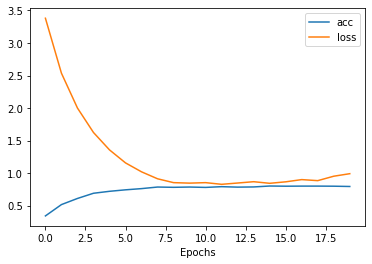

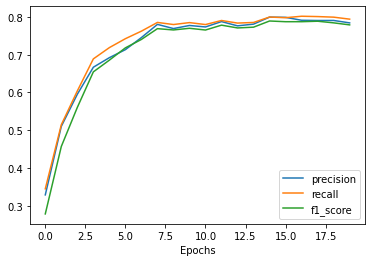

In [40]:
import matplotlib.pyplot as plt


def plot_graphs(history, string, string2):
  plt.plot(history[string])
  plt.plot(history[string2])
  plt.xlabel("Epochs")
  plt.legend([string, string2])
  plt.show()
def plot_graphs2(history, string, string2, string3):
  plt.plot(history[string])
  plt.plot(history[string2])
  plt.plot(history[string3])
  plt.xlabel("Epochs")
  plt.legend([string, string2, string3])
  plt.show()

plot_graphs(tirmidzi, 'acc', 'loss')
plot_graphs2(tirmidzi, 'precision', 'recall', 'f1_score')